# MVA: basic VAE in Pytorch

Here, we'll look at the basics of a deep latent variational model, implemented in Pytorch. I won't be using a GPU, because I won't be training the model, but you may want to use one to train it.

# Loading useful stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F

# Loading Larochelle's binary MNIST

In [ ]:
xtrain = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_train.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xvalid = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_valid.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xtest = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_test.amat',dtype=np.float32).reshape(-1,28, 28,order='C')

p = 784
n = xtrain.shape[0]
ntest = xtest.shape[0]

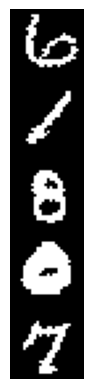

In [ ]:
plt.imshow(xtrain[0:5, :].reshape((28*5,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow {[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a Pytorch sequential model.

In [ ]:
d = 2 # dimension of the latent space

p_z = td.Independent(td.Normal(loc = torch.zeros(d), scale = torch.ones(d)),reinterpreted_batch_ndims=1)  # that's the prior

In [ ]:
num_hidden = 50

decoder = nn.Sequential(
            nn.Linear(d, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 784)
    )

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





# Ancestral sampling

Let us implement ancestral sampling for our simple, two-node graphical model!

In [ ]:
z_samples = p_z.sample((5,))
p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z_samples)), reinterpreted_batch_ndims = 1)
x_samples = p_xgivenz.sample((1,))

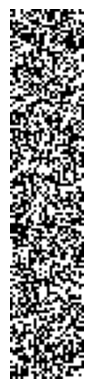

In [ ]:
plt.imshow(x_samples.numpy().reshape((28*5,28)), cmap='gray')
plt.axis('off')
plt.show()

Of course, the samples look like rubbish, because the model is untrained...

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x})$.

In [ ]:
encoder = nn.Sequential(
            nn.Flatten(), # we flatten the images into vectors
            nn.Linear(784, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, d*2) # d*2 because we output both the mean of q and the diagonal of the covariance
    )

Let us now see how to sample from this approximate posterior. For instance, let us take a batch of images $x_1,\ldots,x_{n_B}$, and create the distributions $q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}_1),\ldots, q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}_{n_B})$.

In [ ]:
batch = torch.tensor(xtrain[:10,:])

encoded_batch = encoder(batch)

mu_q = encoded_batch[:,:d]
sigma_q = nn.Softplus()(encoded_batch[:,d:])

q_zgivenx = td.Independent(td.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)

We can now sample from the approximate posterior!

In [ ]:
z_sample = q_zgivenx.sample((1,))

In [ ]:
z_sample_reparametrised = q_zgivenx.rsample((1,))

Try to use this to train a VAE! Note that you will need reparametrised samples to compute the gradients wrt the encoder, so do not forget to use $\texttt{rsample}$ while training!